In [61]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from qiskit import *
from qiskit import IBMQ
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

In [98]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 2  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

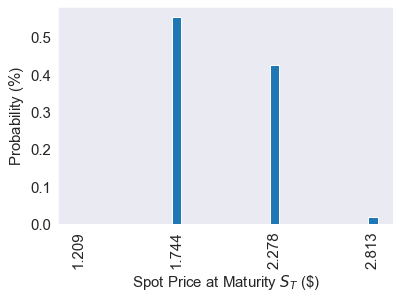

In [99]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.05)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()


In [87]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │  P(X) ││    │
q_1: ┤1      ├┤1   ├
     └───────┘│    │
q_2: ─────────┤2 F ├
              │    │
q_3: ─────────┤3   ├
              │    │
q_4: ─────────┤4   ├
              └────┘

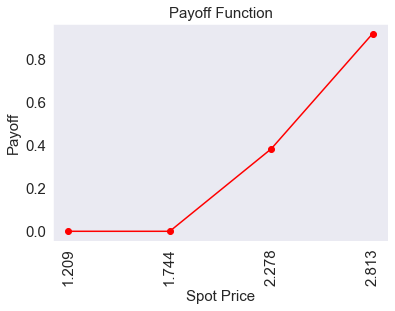

In [105]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [89]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [113]:
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1673
Estimated value:    	0.1847
Confidence interval:	[0.1800, 0.1894]


In [91]:
IBMQ.save_account("2377ac879cf1f5b0d4a0660ee22f22f8cdf2cb39fe123c8d67b88cf5a64257909d14e84c1a43ee83c212d805a3987f7ee3da2da42fff0e35bf6de15220d1e41b")
IBMQ.load_account()

configrc.store_credentials:WARNING:2022-11-02 21:11:07,873: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-11-02 21:11:08,196: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [92]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_belem')

In [ ]:
problem_qc = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae_qc = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qcomp)

result_qc = ae_qc.estimate(problem_qc)

In [ ]:

conf_int = np.array(result_qc.confidence_interval_processed)
# print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result_qc)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

In [ ]:
from scipy.stats import norm,kstest,shapiro,t
def black_scholes(S,K,T,r,q,sigma,call=True):
    d1 = (np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    if call==True:
        return S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-q*T)*norm.cdf(-d1)
    
black_scholes(2,1.896,T,r,0.05,vol,call=True)

In [119]:
from scipy.stats import norm,kstest,shapiro,t
def black_scholes(S,K,T,r,q,sigma,call=True):
    d1 = (np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    if call==True:
        return S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-q*T)*norm.cdf(-d1)
    
black_scholes(2,1.896,T,r,0.05,vol,call=True)

0.16217610559037698